# Positional Encoding

语言是离散序列数据，对于 “喝蜂蜜” 和 “喝蜜蜂”， 虽然其词相同，但由于词之间顺序不同，导致不同的语义。所以语言建模中，序列性对语义的决定是至关重要的。语言模型的输入信息源分两种：

1. embedding：词嵌入
2. position：位置信息，可以是标量、向量或矩阵，等多种信息。


## 分析RNN 模型和Attention 模型

**RNN 模型**

$ h_t = f(h_{t-1} + x_t) $

其中通过上个时刻的 隐状态 $h_{t-1}$ 与当前状态 $x_t$ 进行 变换算子$f(\cdot)$计算得到 当前时刻的 隐状态 $h_t$, 在 RNN 模型中是不需要位置编码的，因为相邻关系就能表示时序关系。

**Attention 模型**

$ h_{1:t} = \texttt{Attn}(x_{1:t}) $

其中，$\texttt{Attn}$ 为注意力算子，多个token的词嵌入，经过序列建模，得到多个token的注意力特征向量。那么为什么 Attention 机制需要 位置编码？

# Attention 示例

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

In [2]:
class Model(nn.Module):
    def __init__(self, vocab_size = 100, d_model = 8):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embd = nn.Embedding(self.vocab_size, self.d_model) 
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x):
        X = self.embd(x)
        Q,K,V = self.wq(X), self.wk(X), self.wv(X)
        O = F.softmax(Q@K.t() / math.sqrt(self.d_model), dim = -1) @  V
        return O
vocab_size = 100
d = 8
model = Model(vocab_size=vocab_size, d_model = d)

In [3]:
# 调整token序列的顺序，发现各个 token 的注意力特征同样置换了顺序
# 对注意力特征进行合并，两个序列的 sum 语义向量是一样的。

input_ids = torch.tensor([3,8,4], dtype = torch.long)
y = model(input_ids)
print('original embd:', y)
print('original sum(embd)', y.sum(dim = 0))

input_ids = torch.tensor([8,3,4], dtype = torch.long)
y = model(input_ids)
print('shift embd:', y)
print('shift sum(embd)', y.sum(dim = 0))

original embd: tensor([[ 0.0300, -0.1316, -0.8533,  0.0848, -0.7631,  0.1411,  0.8940, -0.3497],
        [ 0.0280, -0.1317, -0.8516,  0.0833, -0.7602,  0.1413,  0.8933, -0.3481],
        [-0.0151, -0.1057, -0.4938, -0.5157, -0.2601,  0.2846,  0.6690,  0.1387]],
       grad_fn=<MmBackward0>)
original sum(embd) tensor([ 0.0429, -0.3691, -2.1987, -0.3476, -1.7834,  0.5670,  2.4562, -0.5590],
       grad_fn=<SumBackward1>)
shift embd: tensor([[ 0.0280, -0.1317, -0.8516,  0.0833, -0.7602,  0.1413,  0.8933, -0.3481],
        [ 0.0300, -0.1316, -0.8533,  0.0848, -0.7631,  0.1411,  0.8940, -0.3497],
        [-0.0151, -0.1057, -0.4938, -0.5157, -0.2601,  0.2846,  0.6690,  0.1387]],
       grad_fn=<MmBackward0>)
shift sum(embd) tensor([ 0.0429, -0.3691, -2.1987, -0.3476, -1.7834,  0.5670,  2.4562, -0.5590],
       grad_fn=<SumBackward1>)


## 标量位置信息

In [4]:
class ModelScalar(nn.Module):
    def __init__(self, vocab_size = 100, d_model = 8):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embd = nn.Embedding(self.vocab_size, self.d_model) 
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x):
        seq_len = x.shape[0]
        pe = torch.arange(seq_len).unsqueeze(1) # 标量位置信息
        print(pe)
        X = self.embd(x) 
        X += pe # 输入嵌入位置信息
        Q,K,V = self.wq(X), self.wk(X), self.wv(X)
        O = F.softmax(Q@K.t() / math.sqrt(self.d_model), dim = -1) @  V
        return O
        
model = ModelScalar(vocab_size=vocab_size, d_model = d)

In [5]:
input_ids = torch.tensor([3,8], dtype = torch.long)
seq_len = input_ids.shape[0]
pe = torch.arange(seq_len).unsqueeze(1) # 标量位置信息
print(pe)
print(pe.shape)
X = model.embd(input_ids)
print(X.shape)
print(X)
X_pe = X + pe # 输入嵌入位置信息
print(X_pe)
print(X_pe - X)

tensor([[0],
        [1]])
torch.Size([2, 1])
torch.Size([2, 8])
tensor([[ 1.1900,  1.4109,  0.7980,  0.4941, -0.1850, -1.0381, -0.1013, -0.9272],
        [ 0.0019, -0.2098,  1.2010,  0.6756, -1.8900,  0.1943,  1.6020, -1.0372]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 1.1900,  1.4109,  0.7980,  0.4941, -0.1850, -1.0381, -0.1013, -0.9272],
        [ 1.0019,  0.7902,  2.2010,  1.6756, -0.8900,  1.1943,  2.6020, -0.0372]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],
       grad_fn=<SubBackward0>)


In [6]:
input_ids = torch.tensor([3,8,4], dtype = torch.long)
y = model(input_ids)
print('original embd:', y)
print('original sum(embd)', y.sum(dim = 0))

input_ids = torch.tensor([8,3,4], dtype = torch.long)
y = model(input_ids)
print('shift embd:', y)
print('shift sum(embd)', y.sum(dim = 0))

tensor([[0],
        [1],
        [2]])
original embd: tensor([[-0.5206, -1.0903, -0.7130, -1.0170,  0.3438,  0.3431, -0.9044, -0.5041],
        [-0.5307, -1.1088, -0.7211, -1.0315,  0.3499,  0.3493, -0.9103, -0.5073],
        [-0.5064, -0.7782, -0.4094, -0.2392,  0.2848, -0.0982, -0.7311, -0.7706]],
       grad_fn=<MmBackward0>)
original sum(embd) tensor([-1.5577, -2.9773, -1.8434, -2.2877,  0.9785,  0.5942, -2.5459, -1.7820],
       grad_fn=<SumBackward1>)
tensor([[0],
        [1],
        [2]])
shift embd: tensor([[-0.4739, -1.1378, -0.7953, -1.2794,  0.3479,  0.5181, -0.9114, -0.3476],
        [-0.5354, -0.9868, -0.5982, -0.7020,  0.3260,  0.1536, -0.8556, -0.6392],
        [-0.5572, -0.9030, -0.4915, -0.4087,  0.3161, -0.0205, -0.8030, -0.7655]],
       grad_fn=<MmBackward0>)
shift sum(embd) tensor([-1.5666, -3.0276, -1.8850, -2.3901,  0.9900,  0.6512, -2.5700, -1.7522],
       grad_fn=<SumBackward1>)


上述代码实现中，引入标量位置信息，对输入嵌入位置，可见最终的注意力特征及完整文本语义表示都有变化。

## 注意分数计算

给定位置m，n向量，没有位置信息时：

$$
\begin{align}
& X_mW_Q \times (X_nW_K)^T 
\end{align}
$$

有位置信息

$$
\begin{align}
&(X_m+P_m)W_Q \times ((X_n+P_n)W_K)^T \\
&=(X_mW_Q+P_mW_Q) \times (W_K^TX_n^T+W_K^TP_n^T)\\
&=X_mW_QW_K^TX_n^T + X_mW_Q W_K^TP_n^T +  P_mW_QW_K^TX_n^T + P_mW_QW_K^TP_n^T
\end{align}
$$

其中, $P_mW_QW_K^TP_n^T = (m*I)W_QW_K(n*I) = mn(W_QW_K)$ 可见该项中的两个位置信息产生交互

## Transformer位置编码

根据上述标量位置信息，已能区分调整序列顺序前后的特征向量表示了。缺点在于：

1. 每个维度位置信息一样，表示单一
2. 在注意分数形式下，无法体现位置相对性。

绝对位置编码为

$$
PE(n) = [\sin(n\theta_0),\cos(n\theta_0), \ldots, \sin(n\theta_{d/2-1}),\cos(n\theta_{d/2-1})]
$$

其中，PE(n)表示 位置$n$ 的绝对位置编码向量， $\theta_i = \frac{1}{b^{i*2/d}}$, $b=10000.0$

In [7]:
a = torch.arange(10)
print(a[0::2])
print(a[1::2])

tensor([0, 2, 4, 6, 8])
tensor([1, 3, 5, 7, 9])


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len = 100, d_model = 8, base = 10000.0):
        super().__init__()
        d = d_model // 2
        i = torch.arange(d)
        theta = base ** ( - i * 2 / d_model )
        L = torch.arange(max_len)

        m_theta = torch.outer(L, theta)
        sin = m_theta.sin()
        cos = m_theta.cos()

        self.PE = torch.zeros(max_len, d_model)
        self.PE[:, 0::2] = sin
        self.PE[:, 1::2] = cos
        
        
    def forward(self, x):
        seq_len = x.shape[0]
        return self.PE[:seq_len, :]
 
pe = PositionalEncoding(max_len = 100, d_model = d, base = 10000.0)

input_ids = torch.tensor([3,8,4], dtype = torch.long)
pe(input_ids)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          1.0000e+00,  0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,
          9.9995e-01,  1.0000e-03,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,
          9.9980e-01,  2.0000e-03,  1.0000e+00]])

In [9]:
class ModelPE(nn.Module):
    def __init__(self, vocab_size = 100, d_model = 8, max_len = 100, base = 10000.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embd = nn.Embedding(self.vocab_size, self.d_model) 
        self.PE = PositionalEncoding(max_len = max_len, d_model = d_model, base = base)
        
        self.wq = nn.Linear(d_model, d_model, bias=False)
        self.wk = nn.Linear(d_model, d_model, bias=False)
        self.wv = nn.Linear(d_model, d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        
    def forward(self, x):
        seq_len = x.shape[0]
        X = self.embd(x) + self.PE(x) # addpe
        Q,K,V = self.wq(X), self.wk(X), self.wv(X)
        O = F.softmax(Q@K.t() / math.sqrt(self.d_model), dim = -1) @  V
        return O
        
model = ModelPE(vocab_size=100, d_model = d, max_len = 100,base = 10000.0)

input_ids = torch.tensor([3,8,4], dtype = torch.long)
model(input_ids)

tensor([[ 0.4634,  0.9902,  0.9013,  0.2775, -0.2299, -0.5615,  0.3328,  0.6887],
        [ 0.4799,  0.9777,  0.9167,  0.2635, -0.2255, -0.5605,  0.3273,  0.7106],
        [ 0.4838,  0.9747,  0.9204,  0.2601, -0.2245, -0.5603,  0.3260,  0.7158]],
       grad_fn=<MmBackward0>)

## 绝对位置编码分析



1. 为什么每个维度的角度需要有变化
2. 为什么base要设置成 10000.0
3. 为什么以 sin-cos 为组
5. 位置编码的远程衰减性
6. 可学习位置编码
7. 无位置编码是否可行

## 为什么每个维度的角度需要有变化

In [10]:
d_model = 1024 
base = 10000.0

def get_theta(d_model, base): 
    d = d_model // 2
    i = torch.arange(d)
    theta = base ** ( - i * 2 / d_model )
    return theta

theta = get_theta(d_model, base)
print(theta[:5])
print(theta[-5:])

tensor([1.0000, 0.9822, 0.9647, 0.9475, 0.9306])
tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001])


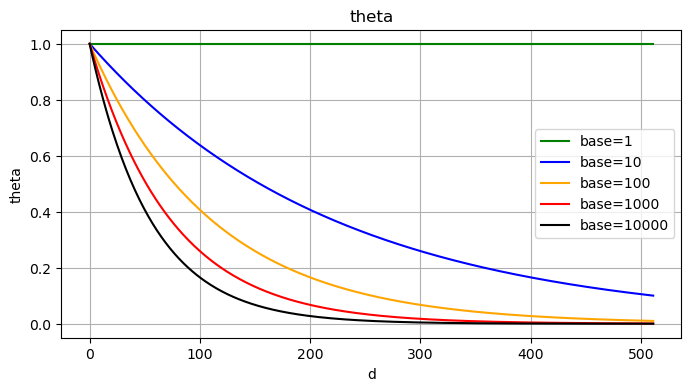

In [11]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))

x = torch.arange(d_model / 2).tolist()
color_list = ['green', 'blue', 'orange', 'red', 'black']
for i in range(5):
    base = 10**i
    y = get_theta(d_model, base).tolist()
    plt.plot(x, y, label=f'base={base}', color=color_list[i], )

plt.title("theta")
plt.xlabel("d")
plt.ylabel("theta")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print('弧度.sin():\t', math.sin(0), math.sin(1))# 弧度对于的 sin 值
print('弧度转角度:\t', math.degrees(0), math.degrees(1)) # 弧度转角度
print('弧度 pi/2:\t', math.pi/2) # 90 degree
print('弧度 pi:\t\t', math.pi) # 180 degree
print('弧度 pi.sin():\t', math.sin(math.pi))

弧度.sin():	 0.0 0.8414709848078965
弧度转角度:	 0.0 57.29577951308232
弧度 pi/2:	 1.5707963267948966
弧度 pi:		 3.141592653589793
弧度 pi.sin():	 1.2246467991473532e-16


更准确说，其theta应为弧度

1. 当 base 为 1 时，每个维度的弧度恒为 1
3. 当 base > 1 时， 曲线单调下降，在低维，下降更快， 在高维，下降放缓
4. 角度弧度值范围 base $\in (0, 1]$, 角度范围在 $0\degree \sim 57.29\degree$
5. 角度变化是非线性的。

## 目标角度

目标角度包含， sin(m*theta), m为位置。

In [13]:
max_len = 512 # 最大序列长度
L = torch.arange(max_len)
theta = get_theta(d_model, base = 10000.0)
m_theta = torch.outer(L, theta)

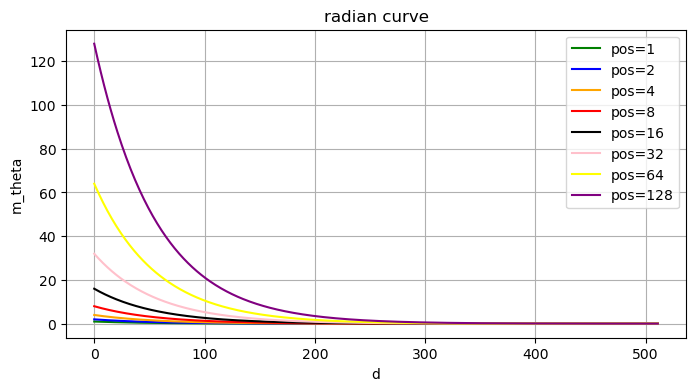

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
x = torch.arange(d_model / 2).tolist()
color_list = ['green', 'blue', 'orange', 'red', 'black', 'pink', 'yellow', 'purple' ]
for i in range(8):
    m = int(2**i)
    plt.plot(x, m_theta[m, :].tolist(), label=f'pos={m}', color=color_list[i], )

plt.title("radian curve")
plt.xlabel("d")
plt.ylabel("m_theta")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print( math.degrees(m_theta[1 , 0]), math.degrees(m_theta[1 , -1]))
print( math.degrees(m_theta[4 , 0]), math.degrees(m_theta[4 , -1]))
print( math.degrees(m_theta[16 , 0]), math.degrees(m_theta[16 , -1]))
print( math.degrees(m_theta[128 , 0]), math.degrees(m_theta[128 , -1]))
print( math.degrees(m_theta[511 , 0]), math.degrees(m_theta[511 , -1]))

57.29577951308232 0.005833579776377594
229.1831180523293 0.023334319105510377
916.7324722093172 0.09333727642204151
7333.859777674537 0.7466982113763321
29278.143331185067 2.9809592236239024


1. 随位置增大，较大增大
2. 角度增大时，如角度超过 $[-\pi/2, \pi/2]$, 其sin值则会周期变化
3. 位置越大，维度越低， 其角度变化大，其sin变化大

## sin 变化

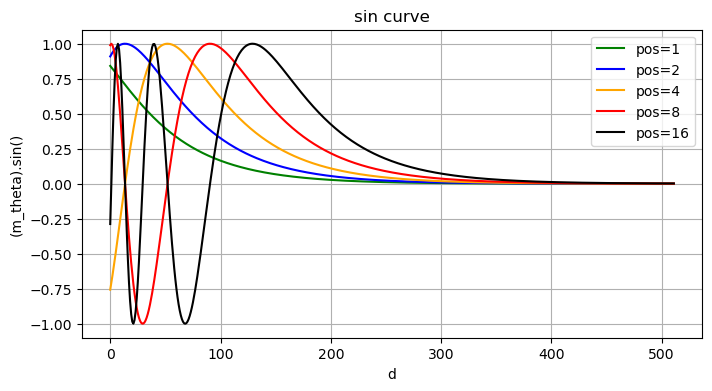

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
x = torch.arange(d_model / 2).tolist()
color_list = ['green', 'blue', 'orange', 'red', 'black', 'pink', 'yellow', 'purple' ]
for i in range(5):
    m = int(2**i)
    plt.plot(x, m_theta[m, :].sin().tolist(), label=f'pos={m}', color=color_list[i], )

plt.title("sin curve")
plt.xlabel("d")
plt.ylabel("(m_theta).sin()")
plt.legend()
plt.grid(True)
plt.show()

## 为什么是 sin-cos

1. 角度范围大， sin，cos周期函数 值域 $[-1,1]$
2. 嵌入了 sin-cos 位置编码的词向量， 在计算注意力分数时，可以显式表示词元之间的相对距离, 推导

$P_mW_QW_K^TP_n^T$ 中，设$W_Q,W_K\in diag(I)$, 则$P_mP_n^T\in \mathbb{R}$, 

取两维 $P'_m = [\sin(m \theta_i), \cos(m \theta_i)]$,$P'_n = [\sin(n\theta_i), \cos(n\theta_i)]$, 有

$P'_m P'^T_n = \cos( (m-n) \theta_i)$ 

> 如何推导？

In [17]:
max_len = 512 # 最大序列长度
L = torch.arange(max_len)
theta = get_theta(d_model, base = 10000.0)
m_theta = torch.outer(L, theta)
sin = m_theta.sin()
cos = m_theta.cos()
PE = torch.zeros(max_len, d_model)
PE[:, 0::2] = sin
PE[:, 1::2] = cos

In [18]:
PE[0, :] @ PE[128, :].t()

tensor(209.5084)

In [19]:
score = PE[0, :] @ PE.t()
print(score.shape)

torch.Size([512])


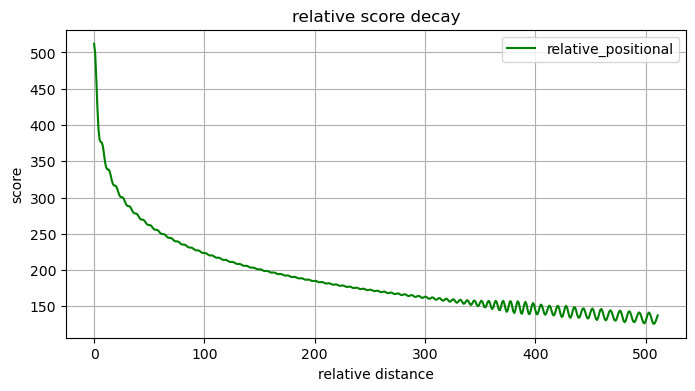

In [20]:

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
x = torch.arange( max_len ).tolist()
plt.plot(x, score.tolist(), label=f'relative_positional', color='green', )

plt.title("relative score decay")
plt.xlabel("relative distance")
plt.ylabel("score")
plt.legend()
plt.grid(True)
plt.show()

## 当有权重矩阵衰减性

In [21]:
# 忽略 bias
WQ = nn.Linear(d_model, d_model, bias = True)
WK = nn.Linear(d_model, d_model, bias = True)

score = WQ(PE[0, :])  @ WK(PE).t()
print(score.shape)

torch.Size([512])


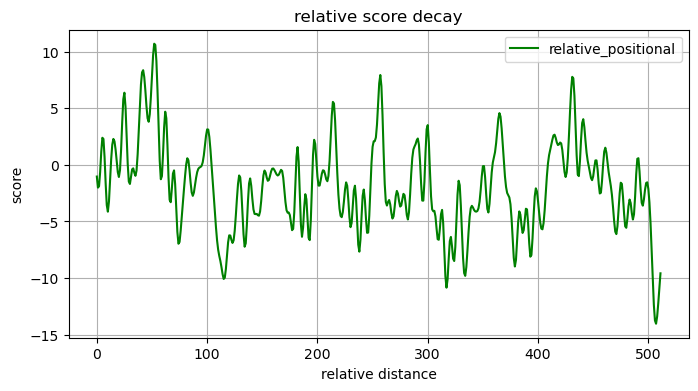

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
x = torch.arange( max_len ).tolist()
plt.plot(x, score.tolist(), label=f'relative_positional', color='green', )

plt.title("relative score decay")
plt.xlabel("relative distance")
plt.ylabel("score")
plt.legend()
plt.grid(True)
plt.show()

1. 关于位置向量，含随机参数(W_Q, W_K)的注意力分数并不呈衰减。
2. TODO，随着训练，$P_mW_QW_K^TP_n^T$ 是否呈衰减

## 可学习位置编码

In [23]:
embd = nn.Embedding(vocab_size, d_model)
pe_learn = nn.Embedding(max_len, d_model)

## 无位置编码 Transformer 可行？

$$
\begin{align}
& X_mW_Q \times (X_nW_K)^T 
\end{align}
$$

强迫 $W_Q$ 和 $W_K$ 学习到位置的感知。对于 Transformer 来说， Decoder 为了预测下一个 token，其构建的注意力特征具有时序性。

加入精心设计的位置编码，对于 decoder 来说是为了增加位置偏置，加快模型收敛。

Encoder 的 attention 特征无时序性。但随着 decoder 反传的梯度，能够一定程度影响 encoder self-attention。

故结论：Transformer中，无位置编码直觉是可行的。